In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import sklearn

df = pd.read_csv('../../data/processed/engineered.csv')

## Initial set of columns

First I'm testing using all of the rolling average columns, and putting them in an XGBoost model

In [2]:
roll_avg_columns = [
    col for col in df.columns 
    if 'avg' in col
    # ('10' in col ) 
]
counting_columns = [
    'days_of_rest', 'home_team', 
]

init_features = roll_avg_columns + counting_columns

target = 'spread'

df[init_features].shape

(45610, 56)

## Baseline model

Linear regression predicting spread for a game based on rolling averages of ppg

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(df[init_features], df[target], test_size=0.2, shuffle=False)

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
delta = y_test - preds

rmse = mean_squared_error(y_test, preds)
print(f"RMSE: {rmse:.2f}")

RMSE: 21.61


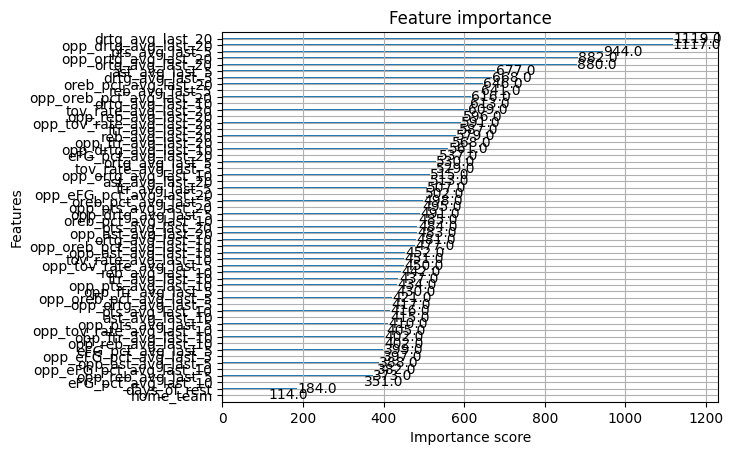

In [4]:
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()

Average delta: -0.06684339253720388
Std. dev. of delta: 4.648435353730203
95% Confidence interval for delta: (-9.1777766858484, 9.044089900773994)


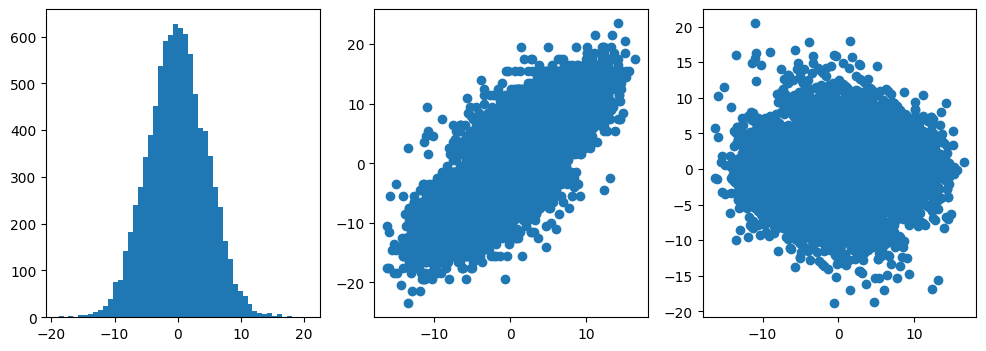

In [5]:
plt.subplots(figsize=(12,4))
plt.gca().set_axis_off()

plt.subplot(1,3,1)
plt.hist(delta, bins=50)

plt.subplot(1,3,2)
plt.scatter(preds, y_test)

plt.subplot(1,3,3)
plt.scatter(preds, delta)

print(f'Average delta: {np.mean(delta)}')
print(f'Std. dev. of delta: {np.std(delta)}')
print(f'95% Confidence interval for delta: ({-1.96*np.std(delta)+np.mean(delta)}, {1.96*np.std(delta)+np.mean(delta)})')